In this file, I will attempt to predict data also using coordinates of the grenade detonation - due to the nature of the game, maps have specific spots where specific grenades are meant to detonate - smoke grenades blocking vision in passages, bombsites and sniping spots, molotovs blocking the passage, flashbangs exploding inside a room where people are expected to be etc.

In [915]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [33]:
inferno = pd.read_csv("data/train-grenades-de_inferno.csv")
mirage = pd.read_csv("data/train-grenades-de_mirage.csv")
inferno

,Unnamed: 0,demo_id,demo_round_id,round_start_tick,weapon_fire_id,team,detonation_raw_x,detonation_raw_y,detonation_raw_z,throw_from_raw_x,throw_from_raw_y,throw_from_raw_z,throw_tick,detonation_tick,LABEL,TYPE,map_name
0,0,5158,46311,159689,6573932,CT,448.4950,3380.300,222.4680,864.899658,2389.010254,144.062393,13344,13566.0,True,flashbang,de_inferno
1,1,5595,55563,397002,7899867,T,778.6860,2274.620,137.7930,455.041687,3182.332275,160.031250,11044,11352.0,True,smoke,de_inferno
2,2,5596,55589,305379,7903151,T,1447.9700,896.635,144.4740,-279.968750,-268.968750,29.181963,3193,3871.0,True,smoke,de_inferno
3,3,5596,55595,397002,7904064,T,2717.1800,318.481,552.7410,1880.825562,571.397339,222.031250,10406,10628.0,True,flashbang,de_inferno
4,4,788,42597,71501,6039404,T,313.6380,2291.220,396.4490,1166.624634,2799.950684,127.641594,2873,3095.0,True,flashbang,de_inferno
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,349,596,42744,45262,6063867,T,2479.9600,-107.194,86.0312,1431.441772,130.297836,127.680000,10722,10952.0,True,molotov,de_inferno
350,350,5596,55582,187969,7902073,T,490.8890,3166.080,162.0310,110.810173,1569.611816,132.013687,11141,11843.0,True,smoke,de_inferno
351,351,5452,51765,93628,7371564,T,982.5730,2677.020,129.9930,611.807983,1969.810059,130.363892,8960,9196.0,True,smoke,de_inferno
352,352,645,42494,370398,6024136,T,-13.2019,1426.310,102.8550,1263.402222,2981.905029,135.901749,7269,8025.0,False,smoke,de_inferno


In [919]:
grenades = pd.concat([inferno, mirage], ignore_index = True)
grenades = grenades.loc[:, ['team','detonation_raw_x','detonation_raw_y', 'detonation_raw_z','throw_from_raw_x', 'throw_from_raw_y', 'throw_from_raw_z', 'throw_tick', 'detonation_tick', 'LABEL', 'TYPE', 'map_name']]
grenades

,team,detonation_raw_x,detonation_raw_y,detonation_raw_z,throw_from_raw_x,throw_from_raw_y,throw_from_raw_z,throw_tick,detonation_tick,LABEL,TYPE,map_name
0,CT,448.495,3380.300,222.4680,864.899658,2389.010254,144.062393,13344,13566.0,True,flashbang,de_inferno
1,T,778.686,2274.620,137.7930,455.041687,3182.332275,160.031250,11044,11352.0,True,smoke,de_inferno
2,T,1447.970,896.635,144.4740,-279.968750,-268.968750,29.181963,3193,3871.0,True,smoke,de_inferno
3,T,2717.180,318.481,552.7410,1880.825562,571.397339,222.031250,10406,10628.0,True,flashbang,de_inferno
4,T,313.638,2291.220,396.4490,1166.624634,2799.950684,127.641594,2873,3095.0,True,flashbang,de_inferno
...,...,...,...,...,...,...,...,...,...,...,...,...
719,T,-1462.400,728.349,-45.9688,-1959.668213,704.495361,-47.968750,14328,14564.0,True,smoke,de_mirage
720,CT,-756.819,-2198.980,-159.1930,-593.158081,-1179.779297,-167.968750,9318,9540.0,False,flashbang,de_mirage
721,CT,-696.054,-1541.940,59.4860,-918.049866,-2595.171631,-167.968750,11433,11657.0,True,flashbang,de_mirage
722,CT,529.241,-1621.910,-262.0000,5.098903,-1576.270996,-170.078476,3034,3342.0,True,smoke,de_mirage


Here we can see the distribution of grenade explosions among coordinates (yellow dots are 'valid' grenades, purple are 'invalid'). We can see clusters of yellow dots, and more spread out distribution of purple dots, which tells us that locations of the detonation might actually mean something.

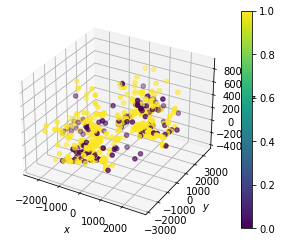

In [920]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cax = ax.scatter(grenades['detonation_raw_x'], grenades['detonation_raw_y'],
                 grenades['detonation_raw_z'], c=grenades['LABEL'])
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
fig.colorbar(cax)
plt.show()

Now we create data as in the other notebook, but also add the detonation coords.

In [921]:
grenades['throw_dist'] = np.sqrt((grenades['throw_from_raw_x'] - grenades['detonation_raw_x'])**2 + 
                                   (grenades['throw_from_raw_y'] - grenades['detonation_raw_y'])**2 +
                                   (grenades['throw_from_raw_z'] - grenades['detonation_raw_z'])**2)
grenades = grenades[['detonation_raw_x', 'detonation_raw_y', 'detonation_raw_z',
                         'team', 'LABEL', 'TYPE','map_name','throw_tick', 'throw_dist']]
grenades

,detonation_raw_x,detonation_raw_y,detonation_raw_z,team,LABEL,TYPE,map_name,throw_tick,throw_dist
0,448.495,3380.300,222.4680,CT,True,flashbang,de_inferno,13344,1078.051779
1,778.686,2274.620,137.7930,T,True,smoke,de_inferno,11044,963.940743
2,1447.970,896.635,144.4740,T,True,smoke,de_inferno,3193,2087.509684
3,2717.180,318.481,552.7410,T,True,flashbang,de_inferno,10406,934.250694
4,313.638,2291.220,396.4490,T,True,flashbang,de_inferno,2873,1028.907444
...,...,...,...,...,...,...,...,...,...
719,-1462.400,728.349,-45.9688,T,True,smoke,de_mirage,14328,497.844023
720,-756.819,-2198.980,-159.1930,CT,False,flashbang,de_mirage,9318,1032.294524
721,-696.054,-1541.940,59.4860,CT,True,flashbang,de_mirage,11433,1100.143034
722,529.241,-1621.910,-262.0000,CT,True,smoke,de_mirage,3034,534.094957


In [922]:
grenades['LABEL'] = grenades['LABEL'].apply(lambda x: 1 if x is True else 0)

In [38]:
dummies = pd.get_dummies(grenades[['team', 'TYPE', 'map_name']])
dummies

,team_CT,team_T,TYPE_flashbang,TYPE_molotov,TYPE_smoke,map_name_de_inferno,map_name_de_mirage
0,1,0,1,0,0,1,0
1,0,1,0,0,1,1,0
2,0,1,0,0,1,1,0
3,0,1,1,0,0,1,0
4,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...
719,0,1,0,0,1,0,1
720,1,0,1,0,0,0,1
721,1,0,1,0,0,0,1
722,1,0,0,0,1,0,1


In [39]:
grenades_num = grenades[['detonation_raw_x', 'detonation_raw_y', 'detonation_raw_z', 'throw_tick', 'throw_dist']]
grenades_num

,detonation_raw_x,detonation_raw_y,detonation_raw_z,throw_tick,throw_dist
0,448.495,3380.300,222.4680,13344,1078.051779
1,778.686,2274.620,137.7930,11044,963.940743
2,1447.970,896.635,144.4740,3193,2087.509684
3,2717.180,318.481,552.7410,10406,934.250694
4,313.638,2291.220,396.4490,2873,1028.907444
...,...,...,...,...,...
719,-1462.400,728.349,-45.9688,14328,497.844023
720,-756.819,-2198.980,-159.1930,9318,1032.294524
721,-696.054,-1541.940,59.4860,11433,1100.143034
722,529.241,-1621.910,-262.0000,3034,534.094957


In [40]:
X = dummies.join(grenades_num)
Y = grenades["LABEL"]

<AxesSubplot:>

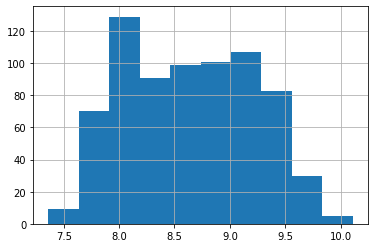

In [41]:
X["throw_tick_norm"] = np.log(X["throw_tick"] + 1)
X["throw_tick_norm"].hist()

In [42]:
X.drop("throw_tick",1,inplace=True)
X

,team_CT,team_T,TYPE_flashbang,TYPE_molotov,TYPE_smoke,map_name_de_inferno,map_name_de_mirage,detonation_raw_x,detonation_raw_y,detonation_raw_z,throw_dist,throw_tick_norm
0,1,0,1,0,0,1,0,448.495,3380.300,222.4680,1078.051779,9.498897
1,0,1,0,0,1,1,0,778.686,2274.620,137.7930,963.940743,9.309733
2,0,1,0,0,1,1,0,1447.970,896.635,144.4740,2087.509684,8.069029
3,0,1,1,0,0,1,0,2717.180,318.481,552.7410,934.250694,9.250234
4,0,1,1,0,0,1,0,313.638,2291.220,396.4490,1028.907444,7.963460
...,...,...,...,...,...,...,...,...,...,...,...,...
719,0,1,0,0,1,0,1,-1462.400,728.349,-45.9688,497.844023,9.570041
720,1,0,1,0,0,0,1,-756.819,-2198.980,-159.1930,1032.294524,9.139811
721,1,0,1,0,0,0,1,-696.054,-1541.940,59.4860,1100.143034,9.344347
722,1,0,0,0,1,0,1,529.241,-1621.910,-262.0000,534.094957,8.017967


Now we want to see the distribution of coords of detonations to know, if we can normalize it.

<AxesSubplot:>

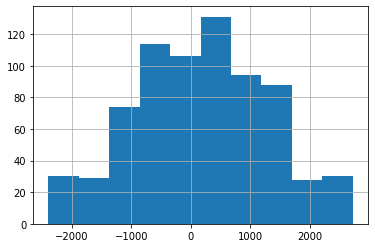

In [43]:
X["detonation_raw_x"].hist()

<AxesSubplot:>

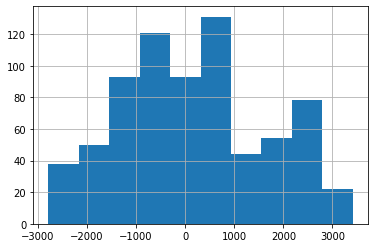

In [44]:
X["detonation_raw_y"].hist()

<AxesSubplot:>

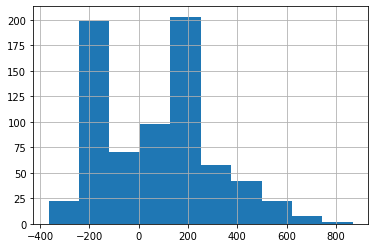

In [45]:
X["detonation_raw_z"].hist()

The distributions are more or less normal, so we can normalize them. throw_dist and throw_tick_norm have normal distributions, as shown in the other notebook.

In [46]:
from sklearn.preprocessing import StandardScaler
import joblib as jl
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[["detonation_raw_x", "detonation_raw_y", "detonation_raw_z",
          "throw_dist", "throw_tick_norm"]] = scaler.fit_transform(X_scaled[["detonation_raw_x",
                                                                             "detonation_raw_y", "detonation_raw_z", 
                                                                             "throw_dist", "throw_tick_norm"]])
jl.dump(scaler, 'scaler.gz')
X_scaled

,team_CT,team_T,TYPE_flashbang,TYPE_molotov,TYPE_smoke,map_name_de_inferno,map_name_de_mirage,detonation_raw_x,detonation_raw_y,detonation_raw_z,throw_dist,throw_tick_norm
0,1,0,1,0,0,1,0,0.263262,2.162695,0.686814,0.089648,1.472557
1,0,1,0,0,1,1,0,0.562037,1.415350,0.300432,-0.113771,1.145835
2,0,1,0,0,1,1,0,1.167643,0.483951,0.330918,1.889142,-0.997096
3,0,1,1,0,0,1,0,2.316096,0.093169,2.193889,-0.166697,1.043068
4,0,1,1,0,0,1,0,0.141236,1.426570,1.480710,0.002041,-1.179434
...,...,...,...,...,...,...,...,...,...,...,...,...
719,0,1,0,0,1,0,1,-1.465824,0.370204,-0.538095,-0.944650,1.595435
720,1,0,1,0,0,0,1,-0.827374,-1.608419,-1.054750,0.008079,0.852346
721,1,0,1,0,0,0,1,-0.772391,-1.164316,-0.056892,0.129028,1.205619
722,1,0,0,0,1,0,1,0.336325,-1.218369,-1.523870,-0.880028,-1.085291


In [47]:
X_and_Y = X_scaled.join(Y)
X_and_Y

,team_CT,team_T,TYPE_flashbang,TYPE_molotov,TYPE_smoke,map_name_de_inferno,map_name_de_mirage,detonation_raw_x,detonation_raw_y,detonation_raw_z,throw_dist,throw_tick_norm,LABEL
0,1,0,1,0,0,1,0,0.263262,2.162695,0.686814,0.089648,1.472557,1
1,0,1,0,0,1,1,0,0.562037,1.415350,0.300432,-0.113771,1.145835,1
2,0,1,0,0,1,1,0,1.167643,0.483951,0.330918,1.889142,-0.997096,1
3,0,1,1,0,0,1,0,2.316096,0.093169,2.193889,-0.166697,1.043068,1
4,0,1,1,0,0,1,0,0.141236,1.426570,1.480710,0.002041,-1.179434,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,0,1,0,0,1,0,1,-1.465824,0.370204,-0.538095,-0.944650,1.595435,1
720,1,0,1,0,0,0,1,-0.827374,-1.608419,-1.054750,0.008079,0.852346,0
721,1,0,1,0,0,0,1,-0.772391,-1.164316,-0.056892,0.129028,1.205619,1
722,1,0,0,0,1,0,1,0.336325,-1.218369,-1.523870,-0.880028,-1.085291,1


Now the data will be split into two sets - 90% of the 'invalid' grenades and 28% of the 'valid' ones are given to the model. This limitation of data is so that there is about 50% of each class in the set, and I also want to prevent overfitting, which would happen if I fed the entire dataset to the model - especially, that the test is taken from the train data. Overfitting would yield the best result, but it is not the point of a prediction model.

In [320]:
grenades["LABEL"].value_counts()

1    573
0    151
Name: LABEL, dtype: int64

In [675]:
X_a_Y_t = X_and_Y.loc[X_and_Y["LABEL"] == 1].sample(frac=0.28)
Y_t = X_a_Y_t["LABEL"]
X_t = X_a_Y_t.drop("LABEL", axis=1)

X_a_Y_f = X_and_Y.loc[X_and_Y["LABEL"] == 0].sample(frac=0.9)
Y_f = X_a_Y_f["LABEL"]
X_f = X_a_Y_f.drop("LABEL", axis=1)

X_even = X_t.append(X_f)
Y_even = Y_t.append(Y_f)

I now try to find a decent classifier that learns on even data. We have to remember, that due to the nature of data and in general a small pool of data, crossvalidation might not be a sensible way of rating the accuracy of the model, checking confusion matrices of train, test and all data is a good way to predict the usability of the model.

In [562]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [563]:
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [680]:
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_even,Y_even)
clf_performance(best_clf_lr,'Logistic Regression')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Logistic Regression
Best Score: 0.5470056497175142
Best Parameters: {'C': 0.0001, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}


In [681]:
confusion_matrix(Y, clf_lr.predict(X_scaled))

array([[ 34, 117],
       [ 67, 506]], dtype=int64)

In [676]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9,11],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2,3]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_even,Y_even)
clf_performance(best_clf_knn,'KNN')

Fitting 5 folds for each of 90 candidates, totalling 450 fits
KNN
Best Score: 0.5640677966101695
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}


In [677]:
confusion_matrix(Y, clf_knn.predict(X_scaled))

array([[146,   5],
       [146, 427]], dtype=int64)

In [678]:
confusion_matrix(Y_even, clf_knn.predict(X_even))

array([[136,   0],
       [  1, 159]], dtype=int64)

In [679]:
confusion_matrix(Y, clf_knn.predict(X_scaled)) - confusion_matrix(Y_even, clf_knn.predict(X_even))

array([[ 10,   5],
       [145, 268]], dtype=int64)

This is a promising result. It was possible to achieve 64% accuracy on predicting the values of valid grenades, and 67% accuracy on predicting the values of invalid grenades, 65% accuracy total. We will save this model for later.


In [734]:
#import joblib as jl
#jl.dump(clf_knn, 'knn_classifier.pkl')

['knn_classifier.pkl']

In [682]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_even,Y_even)
clf_performance(best_clf_svc,'SVC')

Fitting 5 folds for each of 55 candidates, totalling 275 fits
SVC
Best Score: 0.5708474576271186
Best Parameters: {'C': 1000, 'degree': 3, 'kernel': 'poly'}


In [683]:
confusion_matrix(Y, clf_svc.predict(X_scaled))

array([[134,  17],
       [160, 413]], dtype=int64)

In [684]:
confusion_matrix(Y_even, clf_svc.predict(X_even))

array([[127,   9],
       [  7, 153]], dtype=int64)

In [685]:
confusion_matrix(Y, clf_svc.predict(X_scaled)) - confusion_matrix(Y_even, clf_svc.predict(X_even))

array([[  7,   8],
       [153, 260]], dtype=int64)

In [686]:
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [400,450,500,550],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 20, 25],
                                  'max_features': ['auto','sqrt', 10],
                                  'min_samples_leaf': [2,3],
                                  'min_samples_split': [2,3]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_even,Y_even)
clf_performance(best_clf_rf,'Random Forest')

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Random Forest
Best Score: 0.5911864406779661
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 15, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 450}


In [687]:
confusion_matrix(Y, clf_rf.predict(X_scaled))

array([[141,  10],
       [124, 449]], dtype=int64)

In [688]:
confusion_matrix(Y_even, clf_rf.predict(X_even))

array([[135,   1],
       [  0, 160]], dtype=int64)

In [689]:
confusion_matrix(Y, clf_rf.predict(X_scaled)) - confusion_matrix(Y_even, clf_rf.predict(X_even))

array([[  6,   9],
       [124, 289]], dtype=int64)

I decided to create a machine learning model, after some experimenting this one turned out to yield the best results.

In [884]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import SGD
from keras.layers import Dropout
import tensorflow as tf
def create_baseline():
	
	model = Sequential()
	model.add(Dense(32, input_dim=12, activation='relu'))
	model.add(Dropout(0.2))
	model.add(Dense(16, activation='relu'))
	model.add(Dense(8, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	adam=tf.keras.optimizers.Adam(learning_rate=0.0013)
	model.compile(loss='binary_crossentropy', optimizer = adam, metrics=['accuracy'])
	return model

In [933]:
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=100,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

estimator = KerasClassifier(build_fn=create_baseline, epochs=500, batch_size=8, verbose=0)
history = estimator.fit(X_even, Y_even, verbose=2, validation_split = 0.1, callbacks=[early_stopping_monitor])

Epoch 1/500
34/34 - 0s - loss: 0.7248 - accuracy: 0.4398 - val_loss: 0.8064 - val_accuracy: 0.1667
Epoch 2/500
34/34 - 0s - loss: 0.6940 - accuracy: 0.5602 - val_loss: 0.8647 - val_accuracy: 0.1000
Epoch 3/500
34/34 - 0s - loss: 0.6658 - accuracy: 0.6053 - val_loss: 0.9655 - val_accuracy: 0.0333
Epoch 4/500
34/34 - 0s - loss: 0.6730 - accuracy: 0.6015 - val_loss: 0.9455 - val_accuracy: 0.0333
Epoch 5/500
34/34 - 0s - loss: 0.6640 - accuracy: 0.6391 - val_loss: 0.9568 - val_accuracy: 0.0333
Epoch 6/500
34/34 - 0s - loss: 0.6659 - accuracy: 0.5977 - val_loss: 1.0270 - val_accuracy: 0.0000e+00
Epoch 7/500
34/34 - 0s - loss: 0.6550 - accuracy: 0.6278 - val_loss: 0.9850 - val_accuracy: 0.0000e+00
Epoch 8/500
34/34 - 0s - loss: 0.6569 - accuracy: 0.6353 - val_loss: 0.9787 - val_accuracy: 0.0000e+00
Epoch 9/500
34/34 - 0s - loss: 0.6512 - accuracy: 0.6466 - val_loss: 0.9731 - val_accuracy: 0.0333
Epoch 10/500
34/34 - 0s - loss: 0.6522 - accuracy: 0.6015 - val_loss: 1.0102 - val_accuracy: 0.03

Epoch 83/500
34/34 - 0s - loss: 0.4516 - accuracy: 0.7632 - val_loss: 1.7623 - val_accuracy: 0.2000
Epoch 84/500
34/34 - 0s - loss: 0.4427 - accuracy: 0.7857 - val_loss: 1.8787 - val_accuracy: 0.2000
Epoch 85/500
34/34 - 0s - loss: 0.4925 - accuracy: 0.7556 - val_loss: 1.6861 - val_accuracy: 0.2333
Epoch 86/500
34/34 - 0s - loss: 0.4436 - accuracy: 0.8083 - val_loss: 1.8288 - val_accuracy: 0.2333
Epoch 87/500
34/34 - 0s - loss: 0.4465 - accuracy: 0.8045 - val_loss: 1.8931 - val_accuracy: 0.2000
Epoch 88/500
34/34 - 0s - loss: 0.4300 - accuracy: 0.7970 - val_loss: 1.8139 - val_accuracy: 0.1667
Epoch 89/500
34/34 - 0s - loss: 0.4521 - accuracy: 0.7782 - val_loss: 1.9172 - val_accuracy: 0.2000
Epoch 90/500
34/34 - 0s - loss: 0.4443 - accuracy: 0.7632 - val_loss: 1.9117 - val_accuracy: 0.1667
Epoch 91/500
34/34 - 0s - loss: 0.4221 - accuracy: 0.8158 - val_loss: 2.0871 - val_accuracy: 0.1667
Epoch 92/500
34/34 - 0s - loss: 0.4254 - accuracy: 0.7707 - val_loss: 2.0676 - val_accuracy: 0.2000


Epoch 165/500
34/34 - 0s - loss: 0.3455 - accuracy: 0.8158 - val_loss: 2.4337 - val_accuracy: 0.2333
Epoch 166/500
34/34 - 0s - loss: 0.3451 - accuracy: 0.8647 - val_loss: 2.3768 - val_accuracy: 0.2333
Epoch 167/500
34/34 - 0s - loss: 0.3493 - accuracy: 0.8534 - val_loss: 2.5879 - val_accuracy: 0.2000
Epoch 168/500
34/34 - 0s - loss: 0.3345 - accuracy: 0.8308 - val_loss: 2.6782 - val_accuracy: 0.2000
Epoch 169/500
34/34 - 0s - loss: 0.3453 - accuracy: 0.8496 - val_loss: 2.4479 - val_accuracy: 0.2667
Epoch 170/500
34/34 - 0s - loss: 0.3557 - accuracy: 0.8421 - val_loss: 2.3417 - val_accuracy: 0.2333
Epoch 171/500
34/34 - 0s - loss: 0.3419 - accuracy: 0.8308 - val_loss: 2.4635 - val_accuracy: 0.2333
Epoch 172/500
34/34 - 0s - loss: 0.3609 - accuracy: 0.8271 - val_loss: 2.3526 - val_accuracy: 0.2333
Epoch 173/500
34/34 - 0s - loss: 0.3373 - accuracy: 0.8271 - val_loss: 2.6735 - val_accuracy: 0.2333
Epoch 174/500
34/34 - 0s - loss: 0.3415 - accuracy: 0.8271 - val_loss: 2.5544 - val_accurac

Epoch 247/500
34/34 - 0s - loss: 0.3215 - accuracy: 0.8459 - val_loss: 3.2540 - val_accuracy: 0.2333
Epoch 248/500
34/34 - 0s - loss: 0.2502 - accuracy: 0.8835 - val_loss: 3.1828 - val_accuracy: 0.2000
Epoch 249/500
34/34 - 0s - loss: 0.2960 - accuracy: 0.8571 - val_loss: 3.4828 - val_accuracy: 0.2000
Epoch 250/500
34/34 - 0s - loss: 0.2808 - accuracy: 0.8722 - val_loss: 3.2572 - val_accuracy: 0.2333
Epoch 251/500
34/34 - 0s - loss: 0.2826 - accuracy: 0.8722 - val_loss: 3.4127 - val_accuracy: 0.2333
Epoch 252/500
34/34 - 0s - loss: 0.2546 - accuracy: 0.8684 - val_loss: 3.3197 - val_accuracy: 0.2667
Epoch 253/500
34/34 - 0s - loss: 0.3009 - accuracy: 0.8647 - val_loss: 3.1908 - val_accuracy: 0.2667
Epoch 254/500
34/34 - 0s - loss: 0.2802 - accuracy: 0.8647 - val_loss: 3.6515 - val_accuracy: 0.2333
Epoch 255/500
34/34 - 0s - loss: 0.2437 - accuracy: 0.8947 - val_loss: 3.4081 - val_accuracy: 0.2333
Epoch 256/500
34/34 - 0s - loss: 0.2854 - accuracy: 0.8684 - val_loss: 3.2446 - val_accurac

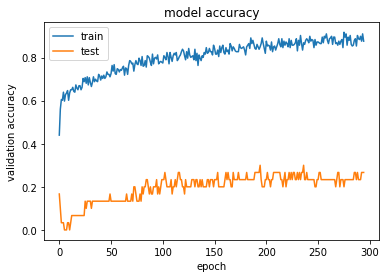

In [934]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Now the model is being tested against the entire dataset and presented in the form of confusion matrix (matrix [i][j], where i is the label, and j is the prediction).

In [935]:
confusion_matrix(Y, estimator.predict(X_scaled))

array([[111,  40],
       [149, 424]], dtype=int64)

The results aren't bad, considering the amount and characteristics of data. About 70% of invalid grenades are properly classified, and about 712% of valid grenades are properly classified. The total accuracy is about 72%. 

Below are results of testing the model on train data.

In [936]:
confusion_matrix(Y_even, estimator.predict(X_even))

array([[101,  35],
       [ 10, 150]], dtype=int64)

And here, we see the resulting matrix on the rest of the data

In [937]:
confusion_matrix(Y, estimator.predict(X_scaled)) - confusion_matrix(Y_even, estimator.predict(X_even))

array([[ 10,   5],
       [139, 274]], dtype=int64)

The results are comparable to these of knn classifier. Here we have 67% accuracy on invalid grenades, and 66% accuracy on valid grenades, 66.3% accuracy total. 

Below, we retrain the network, but this time without a validation split, just to see if it's any better.

In [910]:
early_stopping_monitor_ncv = EarlyStopping(
    monitor='accuracy',
    min_delta=0,
    patience=50,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
estimator.fit(X_even, Y_even, verbose=2, callbacks=[early_stopping_monitor_ncv])

Epoch 1/500
37/37 - 0s - loss: 0.7213 - accuracy: 0.4493
Epoch 2/500
37/37 - 0s - loss: 0.7017 - accuracy: 0.4392
Epoch 3/500
37/37 - 0s - loss: 0.6914 - accuracy: 0.5304
Epoch 4/500
37/37 - 0s - loss: 0.6874 - accuracy: 0.5709
Epoch 5/500
37/37 - 0s - loss: 0.6883 - accuracy: 0.5507
Epoch 6/500
37/37 - 0s - loss: 0.6802 - accuracy: 0.6149
Epoch 7/500
37/37 - 0s - loss: 0.6801 - accuracy: 0.5878
Epoch 8/500
37/37 - 0s - loss: 0.6799 - accuracy: 0.5574
Epoch 9/500
37/37 - 0s - loss: 0.6811 - accuracy: 0.5743
Epoch 10/500
37/37 - 0s - loss: 0.6714 - accuracy: 0.6047
Epoch 11/500
37/37 - 0s - loss: 0.6682 - accuracy: 0.6250
Epoch 12/500
37/37 - 0s - loss: 0.6576 - accuracy: 0.6182
Epoch 13/500
37/37 - 0s - loss: 0.6610 - accuracy: 0.6318
Epoch 14/500
37/37 - 0s - loss: 0.6569 - accuracy: 0.6385
Epoch 15/500
37/37 - 0s - loss: 0.6620 - accuracy: 0.6047
Epoch 16/500
37/37 - 0s - loss: 0.6612 - accuracy: 0.5878
Epoch 17/500
37/37 - 0s - loss: 0.6629 - accuracy: 0.6047
Epoch 18/500
37/37 - 0s

Epoch 142/500
37/37 - 0s - loss: 0.4068 - accuracy: 0.8209
Epoch 143/500
37/37 - 0s - loss: 0.4511 - accuracy: 0.7804
Epoch 144/500
37/37 - 0s - loss: 0.4526 - accuracy: 0.7669
Epoch 145/500
37/37 - 0s - loss: 0.4123 - accuracy: 0.8041
Epoch 146/500
37/37 - 0s - loss: 0.4047 - accuracy: 0.8074
Epoch 147/500
37/37 - 0s - loss: 0.4067 - accuracy: 0.7905
Epoch 148/500
37/37 - 0s - loss: 0.4043 - accuracy: 0.8176
Epoch 149/500
37/37 - 0s - loss: 0.3664 - accuracy: 0.8378
Epoch 150/500
37/37 - 0s - loss: 0.4304 - accuracy: 0.7770
Epoch 151/500
37/37 - 0s - loss: 0.3939 - accuracy: 0.8243
Epoch 152/500
37/37 - 0s - loss: 0.4244 - accuracy: 0.7939
Epoch 153/500
37/37 - 0s - loss: 0.4125 - accuracy: 0.7973
Epoch 154/500
37/37 - 0s - loss: 0.4107 - accuracy: 0.8176
Epoch 155/500
37/37 - 0s - loss: 0.4345 - accuracy: 0.7905
Epoch 156/500
37/37 - 0s - loss: 0.4075 - accuracy: 0.8176
Epoch 157/500
37/37 - 0s - loss: 0.3989 - accuracy: 0.8007
Epoch 158/500
37/37 - 0s - loss: 0.3919 - accuracy: 0.80

Epoch 281/500
37/37 - 0s - loss: 0.3263 - accuracy: 0.8412
Epoch 282/500
37/37 - 0s - loss: 0.3496 - accuracy: 0.8345
Epoch 283/500
37/37 - 0s - loss: 0.3193 - accuracy: 0.8446
Epoch 284/500
37/37 - 0s - loss: 0.3325 - accuracy: 0.8514
Epoch 285/500
37/37 - 0s - loss: 0.3132 - accuracy: 0.8784
Epoch 286/500
37/37 - 0s - loss: 0.3401 - accuracy: 0.8412
Epoch 287/500
37/37 - 0s - loss: 0.3035 - accuracy: 0.8514
Epoch 288/500
37/37 - 0s - loss: 0.3337 - accuracy: 0.8480
Epoch 289/500
37/37 - 0s - loss: 0.3078 - accuracy: 0.8514
Epoch 290/500
37/37 - 0s - loss: 0.3248 - accuracy: 0.8514
Epoch 291/500
37/37 - 0s - loss: 0.3300 - accuracy: 0.8514
Epoch 292/500
37/37 - 0s - loss: 0.3386 - accuracy: 0.8581
Epoch 293/500
37/37 - 0s - loss: 0.2575 - accuracy: 0.8953
Epoch 294/500
37/37 - 0s - loss: 0.3324 - accuracy: 0.8345
Epoch 295/500
37/37 - 0s - loss: 0.2947 - accuracy: 0.8581
Epoch 296/500
37/37 - 0s - loss: 0.3444 - accuracy: 0.8581
Epoch 297/500
37/37 - 0s - loss: 0.3059 - accuracy: 0.86

In [916]:
confusion_matrix(Y, estimator.predict(X_scaled))

array([[131,  20],
       [133, 440]], dtype=int64)

In [917]:
confusion_matrix(Y_even, estimator.predict(X_even))

array([[122,  14],
       [  5, 155]], dtype=int64)

In [918]:
confusion_matrix(Y, estimator.predict(X_scaled)) - confusion_matrix(Y_even, estimator.predict(X_even))

array([[  9,   6],
       [128, 285]], dtype=int64)

The results achieved here are slightly better - 60% accuracy on invalid grenades, and 69% accuracy on valid grenades, 68.6% accuracy total. This model will be put into 'production'.

In [914]:
#estimator.model.save('.')

INFO:tensorflow:Assets written to: .\assets
